# Machine Learning project
- Validate exoplanets Kepler disposition with machine learning methods

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.neural_network import MLPClassifier

## Dataset


In [3]:
df = pd.read_csv('q1_q17_dr24_koi_2023.09.19_04.32.41.csv')
# Rename the columns into more readable names
df.columns =['KepID',"KOIName","KeplerName","ExoplanetArchiveDisposition",
"ExoplanetDispositionKepler","DispositionScore","NotTransit-LikeFalsePositiveFlag",
"koi_fpflag_ss","CentroidOffsetFalsePositiveFlag","EphemerisMatchIndicatesContaminationFalsePositiveFlag",
"OrbitalPeriod.[Days]","OrbitalPeriodErr1.[Days]","OrbitalPeriodErr2.[Days]",
"TransitEpoch-bk","TransitEpoch-bkErr1","TransitEpoch-bkErr2",
"ImpactParameter","ImpactParameterErr1","ImpactParameterErr2",
"TransitDuration.[Hours]","TransitDurationErr1.[Hours]","TransitDurationErr2.[Hours]",
"TransitDepth.[ppm]","TransitDepthErr1.[ppm]","TransitDepthErr2.[ppm]",
"PlanetaryRadius","PlanetaryRadiusErr1","PlanetaryRadiusErr2",
"EquilibriumTemperature.[K]","EquilibriumTemperatureErr1.[K]","EquilibriumTemperatureErr2.[K]",
"InsolationFlux","InsolationFluxErr1","InsolationFlux2",
"TransitSignalToNoise",
"TCEPlanetNumber","TCEDeliveryName",
"StellarEffectiveTemperature.[K]","StellarEffectiveTemperatureErr1.[K]","StellarEffectiveTemperatureErr2.[K]",
"StellarSurfaceGravity","StellarSurfaceGravityErr1","StellarSurfaceGravityErr2",
"StellarRadius","StellarRadiusErr1","StellarRadiusErr2",
"RA.[deg]","Dec.[deg]","KeplerMagnitude.[mag]"]

print("Amount of the columns in the dataset", len(df.columns))

Amount of the columns in the dataset 49


# Modify dataframe
Modify and exoplanets disposition calculated by Kepler into binary form. 
This will be our label vector.

In [4]:
df['ExoplanetCandidate'] = df['ExoplanetDispositionKepler'].apply(lambda x: 0 if x == 'FALSE POSITIVE' else 1)

Clean the dataframe

In [5]:
"""
Selected columns:
"OrbitalPeriod.[Days]",
"TransitEpoch-bk",
"ImpactParameter",
"TransitDuration.[Hours]",
"TransitDepth.[ppm]",
"PlanetaryRadius"
"EquilibriumTemperature.[K]",
"InsolationFlux",
"TransitSignalToNoise",
"StellarSurfaceGravity",
"RA.[deg]","Dec.[deg]","KeplerMagnitude.[mag]"]"""

df = df.drop(columns=['KepID',"KOIName","KeplerName","ExoplanetArchiveDisposition",
"ExoplanetDispositionKepler","DispositionScore","TransitEpoch-bk","NotTransit-LikeFalsePositiveFlag",
"koi_fpflag_ss","CentroidOffsetFalsePositiveFlag","EphemerisMatchIndicatesContaminationFalsePositiveFlag",
"OrbitalPeriodErr1.[Days]","OrbitalPeriodErr2.[Days]",
"TransitEpoch-bkErr1","TransitEpoch-bkErr2",
"ImpactParameterErr1","ImpactParameterErr2",
"TransitDurationErr1.[Hours]","TransitDurationErr2.[Hours]",
"TransitDepthErr1.[ppm]","TransitDepthErr2.[ppm]",
"PlanetaryRadiusErr1","PlanetaryRadiusErr2",
"EquilibriumTemperatureErr1.[K]","EquilibriumTemperatureErr2.[K]",
"InsolationFluxErr1","InsolationFlux2",
"TCEPlanetNumber","TCEDeliveryName",
"StellarEffectiveTemperature.[K]","StellarEffectiveTemperatureErr1.[K]","StellarEffectiveTemperatureErr2.[K]",
"StellarSurfaceGravityErr1","StellarSurfaceGravityErr2",
"StellarRadius","StellarRadiusErr1","StellarRadiusErr2"])
df.head()

,OrbitalPeriod.[Days],ImpactParameter,TransitDuration.[Hours],TransitDepth.[ppm],PlanetaryRadius,EquilibriumTemperature.[K],InsolationFlux,TransitSignalToNoise,StellarSurfaceGravity,RA.[deg],Dec.[deg],KeplerMagnitude.[mag],ExoplanetCandidate
0,2.470613,0.8186,1.74259,14186.0,12.85,1344.0,772.22,6802.0,4.455,286.80847,49.316399,11.338,1
1,2.204735,0.0010,3.88216,6690.6,16.39,2025.0,3973.70,6714.5,4.021,292.24728,47.969521,10.463,1
2,4.887803,0.0260,2.36386,4342.1,4.84,801.0,97.10,2207.8,4.590,297.70935,48.080853,9.174,1
3,3.849372,0.9193,2.66050,1317.3,13.10,2035.0,4055.29,262.6,3.657,294.35654,38.947380,11.432,1
4,4.780328,0.9516,2.03490,977.2,7.07,1396.0,898.71,383.4,4.003,289.73972,44.647419,11.665,1


Drop rows from dataframe that include Nan value

In [6]:
df.isna().any()
print("Shape of the original data format", df.shape)
# Drop the rows that include Nan
df_cleaned = df.dropna()
print("Shape of the cleaned data format", df_cleaned.shape)

Shape of the original data format (7470, 13)
Shape of the cleaned data format (7374, 13)


# Features and labels
Lets create 2 validation sets from the cleaned data frame

In [7]:
# Create a feature matrix X and label vector y.
y = df_cleaned['ExoplanetCandidate'].to_numpy()
X = df_cleaned.drop(columns=['ExoplanetCandidate']).to_numpy()
# Create test and training sets
    # First split the data into train set that contains 75 % 
    # and test set that contains 25 % of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # Second split the test set into test set that contains 50 % of the test set
X_test2, X_val, y_test2, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [8]:
# Check the distribution of the labels
print("Number of zeros in ytrain:", np.sum(y_train == 0))
print("Number of ones in ytrain:", np.sum(y_train == 1))
# Same for second split
print("Number of zeros in ytest:", np.sum(y_test == 0))
print("Number of ones in ytest:", np.sum(y_test == 1))

Number of zeros in ytrain: 2355
Number of ones in ytrain: 3175
Number of zeros in ytest: 758
Number of ones in ytest: 1086


Features in feature matrix

In [9]:
for column in df_cleaned.drop(columns=['ExoplanetCandidate']).columns:
    print(column)

OrbitalPeriod.[Days]
ImpactParameter
TransitDuration.[Hours]
TransitDepth.[ppm]
PlanetaryRadius
EquilibriumTemperature.[K]
InsolationFlux
TransitSignalToNoise
StellarSurfaceGravity
RA.[deg]
Dec.[deg]
KeplerMagnitude.[mag]


# Polynomial logistic regression model
Create a logistic regression model, find the best polynomial and train it with scaled data. 
Print the results. 

In [10]:
save_regression = [1000]
for degree in range(1, 3):
    # Create a polynomial logistic regression model
    clf_poly = LogisticRegression(C=100, max_iter=10000)
    
    # Choose the degree of the polynomial
    poly = PolynomialFeatures(degree)
    # Create the polynomial train features
    X_train_poly = poly.fit_transform(X_train)
    # Scale the data with StandardScaler
    scaler = StandardScaler().fit(X_train_poly)
    X_train_poly = scaler.transform(X_train_poly)
    # Create the polynomial test features
    X_test_poly = poly.fit_transform(X_val)
    # Scale the data with StandardScaler
    scaler = StandardScaler().fit(X_test_poly)
    X_test_poly = scaler.transform(X_test_poly)
    # Train the model
    clf_poly.fit(X_train_poly, y_train) 
    # Predict labels
    y_pred_poly = clf_poly.predict(X_test_poly) 
    #Calculate the accuracy score
    accuracy = accuracy_score(y_val, y_pred_poly)
    # Calculate logistic loss for the validation set
    val_error = log_loss(y_val, y_pred_poly)
    # Save the model information if the accuracy is better than the previous one
    if save_regression[-1] > val_error:
        save_regression = [clf_poly, poly, X_train_poly, X_test_poly, y_pred_poly, degree, accuracy, val_error]

clf_poly = save_regression[0]
poly = save_regression[1]
X_train_poly = save_regression[2]
# Calculate training error
y_pred_train = clf_poly.predict(X_train_poly)
tr_error = log_loss(y_train, y_pred_train)

# Print the results
print("Training error: ", tr_error)
print("Error for validation set: ", save_regression[-1])
print("Accuracy Score: ", save_regression[-2])
print("Degree of the polynomial: ", save_regression[-3])
zeroLabel = np.zeros(len(y_pred_poly))
print("Accuracy Score with zeros: ", accuracy_score(y_val, zeroLabel))


Training error:  6.504803993189678
Error for validation set:  7.505836714436544
Accuracy Score:  0.7917570498915402
Degree of the polynomial:  2
Accuracy Score with zeros:  0.41106290672451196


Test the trained model with other test set defined in up. 

In [11]:
X_train_poly = poly.fit_transform(X_test2)
scaler = StandardScaler().fit(X_train_poly)
X_train_poly = scaler.transform(X_train_poly)

y_pred = clf_poly.predict(X_train_poly) # Predict labels
accuracy = accuracy_score(y_test2, y_pred)
tr_error = log_loss(y_test2, y_pred)
print("Accuracy Score: ", accuracy)
print("Test set error: ", tr_error)

Accuracy Score:  0.7906724511930586
Test set error:  7.5449296139909


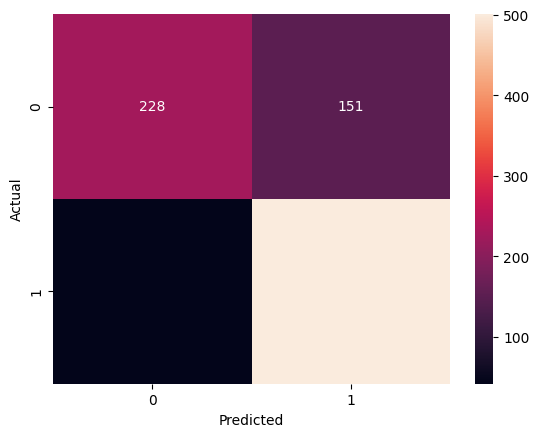

In [12]:
# Plot the confusion matrix
confusionMatrix = confusion_matrix(y_test2, y_pred)
sns.heatmap(confusionMatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Classification report
print("Classification Report: \n", classification_report(y_test2, y_pred))

Classification Report: 


               precision    recall  f1-score   support

           0       0.84      0.60      0.70       379
           1       0.77      0.92      0.84       543

    accuracy                           0.79       922
   macro avg       0.81      0.76      0.77       922
weighted avg       0.80      0.79      0.78       922



# Deep-learning model


Create and test deep-learning model with different layers

In [14]:
## define a list of values for the number of hidden layers
num_layers = [1,4,8,12,20,28,36,44,56,72]    # number of hidden layers ,16,20,28,36,44,56,72
num_neurons = 15  # number of neurons in each layer

# we will use this variable to store the resulting training errors corresponding to different hidden-layer numbers
mlp_tr_error = []          
mlp_val_error = []
save_mlp = []

for i, num in enumerate(num_layers):
    hidden_layer_sizes = tuple([num_neurons]*num) # size (num of neurons) of each layer stacked in a tuple
    
    mlp_regr = MLPClassifier(max_iter=20000, hidden_layer_sizes = hidden_layer_sizes)
    mlp_regr.fit(X_train, y_train)
    
    ## evaluate the trained MLP on both training set and validation set
    y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
    tr_error = log_loss(y_train, y_pred_train)    # calculate the training error
    y_pred_val = mlp_regr.predict(X_val) # predict values for the validation data 
    val_error = log_loss(y_val, y_pred_val) # calculate the validation error
    
    mlp_tr_error.append(tr_error)
    mlp_val_error.append(val_error)
    save_mlp.append(mlp_regr)

print(mlp_tr_error)

mlp_regr = save_mlp[np.array(mlp_val_error).argmin()]

[8.192924468376177, 9.300957212707084, 14.019873135622241, 8.37542397920715, 6.798106778453742, 6.856767335506554, 6.804624618126276, 7.423819387017077, 15.34951242881933, 15.34951242881933]


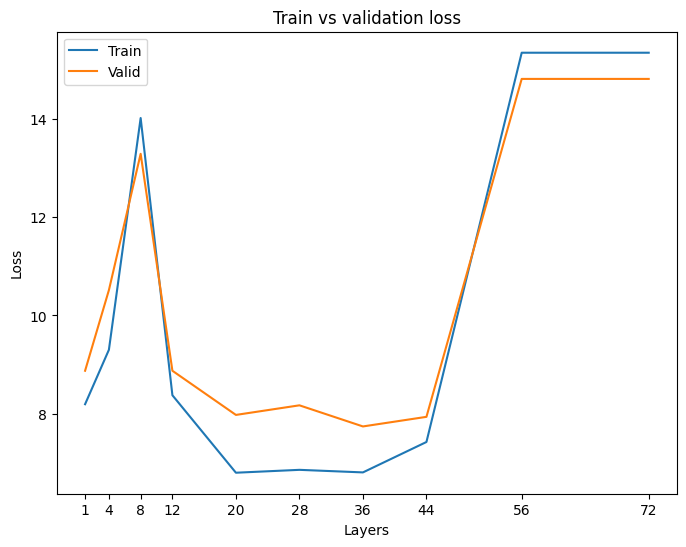

,num_hidden_layers,mlp_train_accuracy,mlp_val_accuracy
0,1,8.192924,8.874088
1,4,9.300957,10.515990
2,8,14.019873,13.291586
3,12,8.375424,8.874088
4,20,6.798107,7.974952
5,28,6.856767,8.170416
6,36,6.804625,7.740394
7,44,7.423819,7.935859
8,56,15.349512,14.816209
9,72,15.349512,14.816209


In [15]:
plt.figure(figsize=(8, 6))

plt.plot(num_layers, mlp_tr_error, label = 'Train')
plt.plot(num_layers, mlp_val_error,label = 'Valid')
plt.xticks(num_layers)
plt.legend(loc = 'upper left')

plt.xlabel('Layers')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()

errors = {"num_hidden_layers":num_layers,
          "mlp_train_accuracy":mlp_tr_error,
          "mlp_val_accuracy":mlp_val_error,
         }
pd.DataFrame(errors)

In [16]:
y_pred_deepLearning = mlp_regr.predict(X_test2) # Predict labels
accuracy = accuracy_score(y_test2, y_pred)
print("Accuracy Score: ", accuracy)

Accuracy Score:  0.7906724511930586


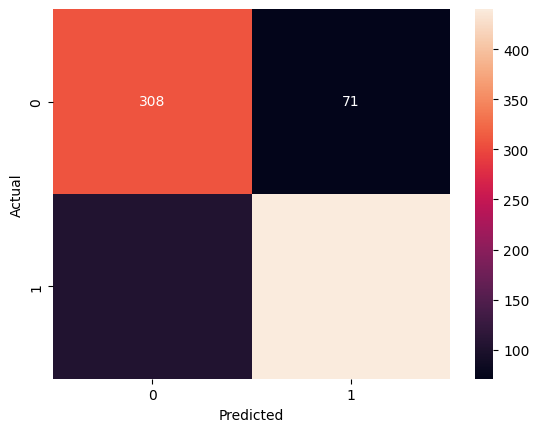

In [17]:
# Plot the confusion matrix
confusionMatrix = confusion_matrix(y_test2, y_pred_deepLearning)
sns.heatmap(confusionMatrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()